# **Model**

# Préparation de la modélisation

## Chargement des données pré-traitées

In [3]:
from pepper.env import get_tmp_dir
import os
import pandas as pd

# Load the preprocessed dataset
def load_prep_dataset(version_name):
    filepath = os.path.join(get_tmp_dir(), f"prep_dataset_{version_name}.pqt")
    data = pd.read_parquet(filepath, engine="pyarrow")
    return data

In [4]:
data_v1 = load_prep_dataset("v1")
display(data_v1)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_True,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_True,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,True,False,False,True,False,False,True,False,False,True
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,True,False,False,True,False,False,True,False,False,True
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,True,False,False,True,False,False,True,False,False,True
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,False,True,False,False,True,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,True,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,-1,0,121500.0,412560.0,17473.5,270000.0,0.002042,-19970,-5169,...,True,False,False,True,False,False,True,False,False,True
356251,456222,-1,2,157500.0,622413.0,31909.5,495000.0,0.035792,-11186,-1149,...,True,False,False,True,False,False,True,False,False,True
356252,456223,-1,1,202500.0,315000.0,33205.5,315000.0,0.026392,-15922,-3037,...,True,False,False,True,False,False,True,False,False,True
356253,456224,-1,0,225000.0,450000.0,25128.0,450000.0,0.018850,-13968,-2731,...,True,False,False,True,False,False,True,False,False,True


In [5]:
data_v2 = load_prep_dataset("v1")
display(data_v2)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_True,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_True,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,True,False,False,True,False,False,True,False,False,True
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,True,False,False,True,False,False,True,False,False,True
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,True,False,False,True,False,False,True,False,False,True
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,False,True,False,False,True,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,True,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,-1,0,121500.0,412560.0,17473.5,270000.0,0.002042,-19970,-5169,...,True,False,False,True,False,False,True,False,False,True
356251,456222,-1,2,157500.0,622413.0,31909.5,495000.0,0.035792,-11186,-1149,...,True,False,False,True,False,False,True,False,False,True
356252,456223,-1,1,202500.0,315000.0,33205.5,315000.0,0.026392,-15922,-3037,...,True,False,False,True,False,False,True,False,False,True
356253,456224,-1,0,225000.0,450000.0,25128.0,450000.0,0.018850,-13968,-2731,...,True,False,False,True,False,False,True,False,False,True


## Overview

Les deux fichiers sont identiques (en attendant une meilleure version basée sur le fruit de notre travail approfondi d'analyse exploratoire). A partir d'ici, on n'en conserve qu'un en tant que `data`.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 790 entries, SK_ID_CURR to CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
dtypes: bool(169), float64(580), int64(41)
memory usage: 1.7 GB


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,356255.000000,356255.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,356255.000000,...,3.395870e+05,3.395870e+05,3.395780e+05,3.395780e+05,3.395780e+05,3.395870e+05,339578.000000,339578.000000,339587.00000,339587.000000
mean,278128.000000,-0.067140,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,-16041.248841,64317.231413,...,1.861577e+04,6.831369e+05,5.282753e+03,1.400438e+05,1.900381e+04,6.904942e+05,-328.433435,-922.095504,-42103.40703,40.064552
std,102842.104413,0.449443,0.720378,2.235068e+05,3.986237e+05,14732.808190,3.660650e+05,0.013915,4358.803980,141705.532576,...,2.346509e+04,8.933805e+05,1.449867e+04,2.496554e+05,2.523135e+04,9.308977e+05,537.367821,597.181989,56863.13532,41.053343
min,100001.000000,-1.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000253,-25229.000000,-17912.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,2.250000e-01,1.890000e-01,0.000000e+00,-3071.000000,-3071.000000,-602499.00000,1.000000
25%,189064.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,2.340000e+05,0.010006,-19676.000000,-2781.000000,...,7.897470e+03,1.366834e+05,4.153500e+01,1.439653e+04,7.582365e+03,1.332007e+05,-387.000000,-1312.043107,-49853.00000,12.000000
50%,278128.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,4.500000e+05,0.018850,-15755.000000,-1224.000000,...,1.272616e+04,3.343952e+05,2.323575e+03,3.703561e+04,1.240398e+04,3.248035e+05,-65.000000,-806.576364,-21233.00000,25.000000
75%,367191.500000,0.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,6.750000e+05,0.028663,-12425.000000,-290.000000,...,2.164516e+04,8.577727e+05,7.158724e+03,1.350000e+05,2.164505e+04,8.497309e+05,-26.000000,-433.857143,-6832.00000,51.000000
max,456255.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7338.000000,365243.000000,...,2.504590e+06,3.247978e+07,2.504590e+06,3.771488e+06,2.504590e+06,3.268928e+07,-1.000000,-3.000000,0.00000,372.000000


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
SK_ID_CURR,356255,356255,0,1.0,1.000000,int64
TARGET,356255,3,0,1.0,0.000008,int64
CNT_CHILDREN,356255,16,0,1.0,0.000045,int64
AMT_INCOME_TOTAL,356255,2741,0,1.0,0.007694,float64
AMT_CREDIT,356255,6480,0,1.0,0.018189,float64
...,...,...,...,...,...,...
OCCUPATION_TYPE_IT_staff,356255,2,0,1.0,0.000006,bool
OCCUPATION_TYPE_Laborers,356255,2,0,1.0,0.000006,bool
OCCUPATION_TYPE_Low_skill_Laborers,356255,2,0,1.0,0.000006,bool
OCCUPATION_TYPE_Managers,356255,2,0,1.0,0.000006,bool


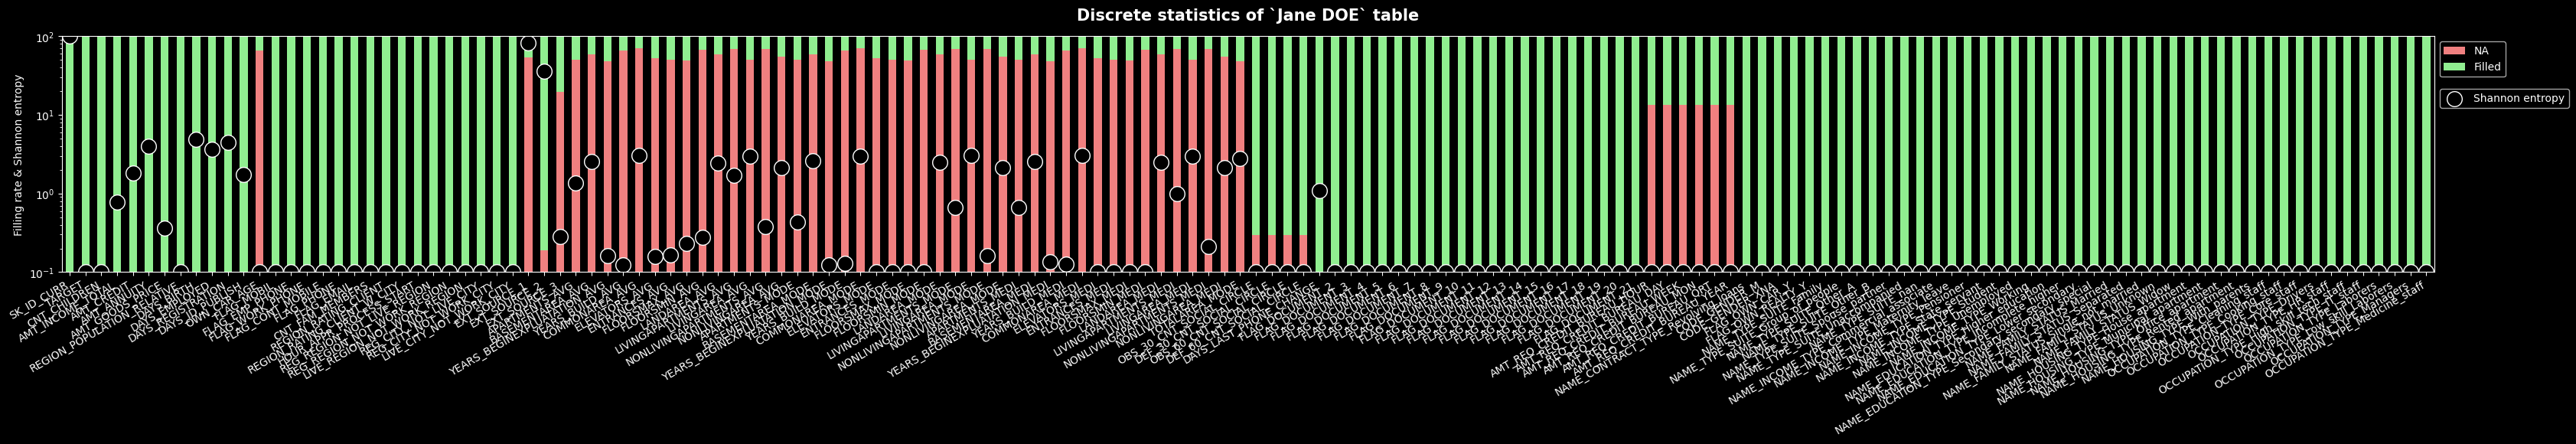

In [10]:
from pepper.utils import show_discrete_stats
data = data_v1
data.info()
display(data.describe())
show_discrete_stats(data[data.columns[:150]], ratio=5)

## Imputation des valeurs manquantes

**TODO**

## Réduction de dimenstionnalité

**TODO**

## Echantillonnage avec rééquilibrage de classes

Les deux classes cibles sont déséquilibrées : les clients défaillants ne représentent que $8\,\%$ des clients.

Ce sont pourtant ces clients qu'il faut spécialement pourvoir identifier en minimisant les faux négatifs plutôt que les faux positifs.

Pour entraîner un modèle à reconnaître ces cas de défaillance, il convient de lui fournir un échantillon ré-équilibré (où la moitié de l'effectif correspond à ces cas de défaillance).

Il existe plusieurs techniques de sous-échantillonnage (par exemple le sous échantillonnage aléatoire ou NearMiss), sur-échantillonnage (par exemple SMOTE et ses variantes) et combinées des deux (par exemple SMOTETomek).

La plupart de ces techniques sont mises en oeuvre par la librairie [**`imblearn`**](https://imbalanced-learn.org/stable/install.html) que nous allons utiliser.

### Exemple de sous-échantillonnage

Exemple d'utilisation de [**`RandomUnderSampler`**](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) (extrait de la documentation de l'API).

In [9]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
X, y = make_classification(
    n_classes=2, class_sep=2,
    weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10
)
print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 100, 1: 100})


### Exemple de sur-échantillonnage

Exemple d'utilisation de [**`SMOTE`**](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) (extrait de la documentation de l'API).

In [4]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 900, 1: 900})


### Exemple hybride

Exemple d'utilisation de [**`SMOTETomek`**](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html) (extrait de la documentation de l'API).

In [5]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))

smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 900, 1: 900})


## Séparation du jeu en 3 sous-jeux d'entraînement, test et validation

## Normalisation des données : StandardScaler ou MinMaxScaler

## Evaluation des modèles

Extrait du kernel

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score

def eval_model(
    nfolds: int,
    stratified: bool = False,
):
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits=nfolds, shuffle=True, random_state=42)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_features, target)):
        # Split the training and validation data using the current fold
        X_y_split = lambda idx: (train_features.iloc[idx], target.iloc[idx])
        X_y_train = X_y_split(train_idx)
        X_y_valid = X_y_split(valid_idx)
        X_valid, y_valid = X_y_valid


In [ ]:
import numpy as np
import pandas as pd
from typing import List, Tuple
from sklearn.metrics import fbeta_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import ClassifierMixin

# A revoir :
# on passe data, qui est la version produite en sortie des étapes de préparation cf. lightgbm_v2
# il faut spérare la préparation des données de l'appel de LGBM
# on enregistre ce fichier en pqt pour pouvoir le recharger, et pour disposer de
# plusieurs versions suivant divers paramètres liés aux choix préparatoires des données (feature engineering)

# De là, on commence par appeler une fonction qui fait d'abord la partition train/test :
# Divide in training/validation and test data
"""
train_data = data[data.TARGET > -1].copy()
test_data = data[data.TARGET == -1].copy()
free(data)
"""

def kfold_model_eval(
    model: ClassifierMixin,
    data: pd.DataFrame,
    # X: pd.DataFrame,
    # y: pd.Series,
    # X_test: pd.DataFrame,
    # y_test: pd.Series,
    nfolds: int,
    stratified: bool = False,
    loss_func=None
) -> Tuple[Tuple[np.ndarray, float], Tuple[np.ndarray, float]]:
    """
    Cross-validates the model, calculate AUC and F2 scores, fit the model with the whole training data,
    predict test labels, calculate AUC and F2 scores on the test set, and return all scores.
    
    Parameters:
    -----------
    model: sklearn-like classifier
        A machine learning model to fit and evaluate.
    data : pd.DataFrame
        The input DataFrame containing the features and target variable.
    nfolds: int
        The number of folds to use for cross-validation.
    stratified: bool, default=False
        Whether to use stratified K-fold cross-validation or not.
    loss_func: callable, default=None
        The evaluation metric to use for model training. If None, use the default metric for the model.
        
    Returns:
    --------
    Tuple[Tuple[np.ndarray, float], Tuple[np.ndarray, float]]
        A tuple containing two tuples. The first tuple contains the cross-validation F2 scores and the test set F2 score.
        The second tuple contains the cross-validation AUC scores and the test set AUC score.
    """
    # Divide in training/validation and test data
    train_data = data[data.TARGET > -1].copy()
    test_data = data[data.TARGET == -1].copy()
    #free(data)

    # Print the shape of the training and test data
    print(f"Starting LightGBM. Train shape: {train_data.shape}, test shape: {test_data.shape}")

    cv_auc_scores = []
    cv_f2_scores = []
    y_pred_proba = []

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits=nfolds, shuffle=True, random_state=42)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_data.shape[0])
    sms_preds = np.zeros(test_data.shape[0])

    # Get the feature names for the training data, excluding some non-feature columns
    not_feat_names = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"]
    feat_names = train_data.columns.difference(not_feat_names)
    
    # Get the target variable and the features for training and test data
    target = train_data.TARGET
    train_features = train_data[feat_names]
    test_features = test_data[feat_names]

    # Iterate through the folds
    fold_imps = []
    for train_idx, valid_idx in folds.split(X, y):
        # Split the training and validation data using the current fold
        X_y_split = lambda idx: (X.iloc[idx], y.iloc[idx])
        X_train, y_train = X_y_split(train_idx)
        X_valid, y_valid = X_y_split(valid_idx)

        # Train the model with or without the loss function specified by loss_func
        if loss_func is None:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train, eval_metric=loss_func)

        # Predict validation data and compute evaluation metrics
        y_pred = model.predict(X_valid)
        y_proba = model.predict_proba(y_valid)
        y_pred_proba.append(list(y_proba[:,1]))

        auc_score = round(roc_auc_score(y_valid, y_pred), 3)
        cv_auc_scores.append(auc_score)

        f2_score = round(fbeta_score(y_valid, y_pred, beta=2), 3)
        cv_f2_scores.append(f2_score)
        
    # Train the model using the whole training set
    if loss_func is None:
        model.fit(X, y)
    else:
        model.fit(X, y, eval_metric=loss_func)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the AUC and F2 scores for the test set
    auc_score_test = round(roc_auc_score(y_test, y_pred), 3)
    f2_score_test = round(fbeta_score(y_test, y_pred, beta=2), 3)

    return (
        (np.array(cv_f2_scores), f2_score_test),
        (np.array(cv_auc_scores), auc_score_test)
    )

# Benchmark des modèles

## Modéle de référence : classifieur naïf

Nous utilisons un [**`DummyClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) de Scikit-learn paramétré avec `strategy="most_frequent"`. Paramétré avec cette stratégie, le classifieur naïf prédira systématiquement la classe dominante.

Ce classifieur va nous servir de point de comparaison pour nous assurer de la réalité des performances prédictives des classifieurs plus avancés.

In [6]:
import numpy as np
from sklearn.dummy import DummyClassifier
X = np.array([-1, 1, 1, 1])
y = np.array([0, 1, 1, 1])
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)

dummy_clf.predict(X)

dummy_clf.score(X, y)

0.75

## Régression Logistique

## Forêt aléatoire

## LGBM

# Choix du meilleur modèle

# Importances des caractéristiques